In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [14]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=tf.nn.sigmoid(targetQs))) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                     labels=tf.zeros_like(targetQs))) # 0-1
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    dlossQ /= 2
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [15]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [16]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [17]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [18]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [19]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [20]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [21]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*2):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dlossA, dlossQ, _ = sess.run([model.d_lossA, model.d_lossQ, model.d_optA], #, model.d_optQ
                                         feed_dict = {model.states: states, 
                                                      model.actions: actions,
                                                      model.targetQs: targetQs, 
                                                      model.rates: rates})
            gloss, _ = sess.run([model.g_loss, model.g_opt], #, model.d_optQ
                                feed_dict = {model.states: states, 
                                             model.actions: actions,
                                             model.targetQs: targetQs, 
                                             model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:13.0000 R:13.0000 rate:0.0260 gloss:1.3776 dlossA:2.0500 dlossQ:0.5114 exploreP:0.9987
Episode:1 meanR:43.5000 R:74.0000 rate:0.1480 gloss:1.3709 dlossA:2.0242 dlossQ:0.4799 exploreP:0.9914
Episode:2 meanR:49.0000 R:60.0000 rate:0.1200 gloss:1.3556 dlossA:1.9653 dlossQ:0.4338 exploreP:0.9856
Episode:3 meanR:40.5000 R:15.0000 rate:0.0300 gloss:1.3477 dlossA:1.9310 dlossQ:0.4064 exploreP:0.9841
Episode:4 meanR:37.6000 R:26.0000 rate:0.0520 gloss:1.3465 dlossA:1.9249 dlossQ:0.4053 exploreP:0.9816
Episode:5 meanR:33.1667 R:11.0000 rate:0.0220 gloss:1.3423 dlossA:1.9024 dlossQ:0.4003 exploreP:0.9805
Episode:6 meanR:31.5714 R:22.0000 rate:0.0440 gloss:1.3382 dlossA:1.8903 dlossQ:0.4036 exploreP:0.9784
Episode:7 meanR:29.2500 R:13.0000 rate:0.0260 gloss:1.3386 dlossA:1.8831 dlossQ:0.3676 exploreP:0.9771
Episode:8 meanR:28.6667 R:24.0000 rate:0.0480 gloss:1.3338 dlossA:1.8662 dlossQ:0.3741 exploreP:0.9748
Episode:9 meanR:28.2000 R:24.0000 rate:0.0480 gloss:1.3270 dlossA:1.8497 

Episode:79 meanR:23.7875 R:18.0000 rate:0.0360 gloss:1.1823 dlossA:1.4290 dlossQ:0.6117 exploreP:0.8284
Episode:80 meanR:23.7037 R:17.0000 rate:0.0340 gloss:1.2024 dlossA:1.4551 dlossQ:0.6141 exploreP:0.8271
Episode:81 meanR:23.5732 R:13.0000 rate:0.0260 gloss:1.2228 dlossA:1.4940 dlossQ:0.6248 exploreP:0.8260
Episode:82 meanR:23.5060 R:18.0000 rate:0.0360 gloss:1.2193 dlossA:1.4886 dlossQ:0.6060 exploreP:0.8245
Episode:83 meanR:23.5357 R:26.0000 rate:0.0520 gloss:1.2074 dlossA:1.4539 dlossQ:0.6047 exploreP:0.8224
Episode:84 meanR:23.4706 R:18.0000 rate:0.0360 gloss:1.2172 dlossA:1.4647 dlossQ:0.6447 exploreP:0.8209
Episode:85 meanR:23.4186 R:19.0000 rate:0.0380 gloss:1.2056 dlossA:1.4569 dlossQ:0.6043 exploreP:0.8194
Episode:86 meanR:23.3793 R:20.0000 rate:0.0400 gloss:1.2043 dlossA:1.4696 dlossQ:0.6147 exploreP:0.8178
Episode:87 meanR:23.4318 R:28.0000 rate:0.0560 gloss:1.1843 dlossA:1.4132 dlossQ:0.5974 exploreP:0.8155
Episode:88 meanR:23.5730 R:36.0000 rate:0.0720 gloss:1.1995 dlos

Episode:158 meanR:21.2000 R:38.0000 rate:0.0760 gloss:1.1576 dlossA:1.3491 dlossQ:0.5862 exploreP:0.7015
Episode:159 meanR:21.2100 R:14.0000 rate:0.0280 gloss:1.1476 dlossA:1.3356 dlossQ:0.5882 exploreP:0.7005
Episode:160 meanR:21.0900 R:15.0000 rate:0.0300 gloss:1.1711 dlossA:1.3710 dlossQ:0.5920 exploreP:0.6995
Episode:161 meanR:20.9800 R:16.0000 rate:0.0320 gloss:1.1538 dlossA:1.3610 dlossQ:0.5764 exploreP:0.6984
Episode:162 meanR:20.9100 R:11.0000 rate:0.0220 gloss:1.1401 dlossA:1.3343 dlossQ:0.5971 exploreP:0.6976
Episode:163 meanR:20.9100 R:17.0000 rate:0.0340 gloss:1.1605 dlossA:1.3437 dlossQ:0.5867 exploreP:0.6964
Episode:164 meanR:20.8600 R:12.0000 rate:0.0240 gloss:1.1666 dlossA:1.3570 dlossQ:0.5793 exploreP:0.6956
Episode:165 meanR:20.8700 R:15.0000 rate:0.0300 gloss:1.1562 dlossA:1.3501 dlossQ:0.5810 exploreP:0.6946
Episode:166 meanR:20.7900 R:14.0000 rate:0.0280 gloss:1.1611 dlossA:1.3487 dlossQ:0.5845 exploreP:0.6936
Episode:167 meanR:20.9200 R:28.0000 rate:0.0560 gloss:1

Episode:237 meanR:15.1500 R:10.0000 rate:0.0200 gloss:1.1188 dlossA:1.2981 dlossQ:0.5567 exploreP:0.6273
Episode:238 meanR:15.1800 R:13.0000 rate:0.0260 gloss:1.1238 dlossA:1.2931 dlossQ:0.5980 exploreP:0.6265
Episode:239 meanR:14.9700 R:9.0000 rate:0.0180 gloss:1.0931 dlossA:1.2641 dlossQ:0.5751 exploreP:0.6260
Episode:240 meanR:14.9300 R:12.0000 rate:0.0240 gloss:1.1334 dlossA:1.3030 dlossQ:0.5836 exploreP:0.6252
Episode:241 meanR:14.8500 R:9.0000 rate:0.0180 gloss:1.1220 dlossA:1.2912 dlossQ:0.5659 exploreP:0.6247
Episode:242 meanR:14.7700 R:8.0000 rate:0.0160 gloss:1.1281 dlossA:1.2912 dlossQ:0.5678 exploreP:0.6242
Episode:243 meanR:14.7700 R:9.0000 rate:0.0180 gloss:1.1106 dlossA:1.2774 dlossQ:0.5783 exploreP:0.6236
Episode:244 meanR:14.7500 R:11.0000 rate:0.0220 gloss:1.1147 dlossA:1.2829 dlossQ:0.5688 exploreP:0.6230
Episode:245 meanR:14.8500 R:19.0000 rate:0.0380 gloss:1.1206 dlossA:1.2897 dlossQ:0.5672 exploreP:0.6218
Episode:246 meanR:14.8900 R:15.0000 rate:0.0300 gloss:1.120

Episode:316 meanR:13.5900 R:12.0000 rate:0.0240 gloss:1.1320 dlossA:1.3059 dlossQ:0.5296 exploreP:0.5650
Episode:317 meanR:13.5900 R:13.0000 rate:0.0260 gloss:1.1178 dlossA:1.2797 dlossQ:0.5460 exploreP:0.5643
Episode:318 meanR:13.4200 R:12.0000 rate:0.0240 gloss:1.1343 dlossA:1.3003 dlossQ:0.5449 exploreP:0.5636
Episode:319 meanR:13.4200 R:15.0000 rate:0.0300 gloss:1.1123 dlossA:1.2841 dlossQ:0.5562 exploreP:0.5628
Episode:320 meanR:13.3700 R:8.0000 rate:0.0160 gloss:1.1467 dlossA:1.3179 dlossQ:0.5516 exploreP:0.5624
Episode:321 meanR:13.3600 R:14.0000 rate:0.0280 gloss:1.1408 dlossA:1.3101 dlossQ:0.5639 exploreP:0.5616
Episode:322 meanR:13.3800 R:14.0000 rate:0.0280 gloss:1.1252 dlossA:1.2944 dlossQ:0.5564 exploreP:0.5608
Episode:323 meanR:13.3900 R:14.0000 rate:0.0280 gloss:1.1527 dlossA:1.3225 dlossQ:0.5692 exploreP:0.5600
Episode:324 meanR:13.4300 R:18.0000 rate:0.0360 gloss:1.1457 dlossA:1.3189 dlossQ:0.5487 exploreP:0.5591
Episode:325 meanR:13.4400 R:11.0000 rate:0.0220 gloss:1.

Episode:395 meanR:12.8200 R:9.0000 rate:0.0180 gloss:1.1998 dlossA:1.3581 dlossQ:0.7493 exploreP:0.5134
Episode:396 meanR:12.8400 R:16.0000 rate:0.0320 gloss:1.1340 dlossA:1.2965 dlossQ:0.5629 exploreP:0.5126
Episode:397 meanR:12.8200 R:9.0000 rate:0.0180 gloss:1.1359 dlossA:1.3009 dlossQ:0.5686 exploreP:0.5121
Episode:398 meanR:12.8400 R:12.0000 rate:0.0240 gloss:1.1279 dlossA:1.3029 dlossQ:0.5576 exploreP:0.5115
Episode:399 meanR:12.9000 R:17.0000 rate:0.0340 gloss:1.1229 dlossA:1.2897 dlossQ:0.5635 exploreP:0.5106
Episode:400 meanR:12.9400 R:13.0000 rate:0.0260 gloss:1.1405 dlossA:1.3135 dlossQ:0.5505 exploreP:0.5100
Episode:401 meanR:12.9200 R:10.0000 rate:0.0200 gloss:1.1360 dlossA:1.3070 dlossQ:0.5559 exploreP:0.5095
Episode:402 meanR:12.9100 R:12.0000 rate:0.0240 gloss:1.1371 dlossA:1.3051 dlossQ:0.5520 exploreP:0.5089
Episode:403 meanR:12.9400 R:13.0000 rate:0.0260 gloss:1.1454 dlossA:1.3108 dlossQ:0.5938 exploreP:0.5083
Episode:404 meanR:12.9800 R:15.0000 rate:0.0300 gloss:1.1

Episode:474 meanR:12.8800 R:10.0000 rate:0.0200 gloss:1.1133 dlossA:1.2894 dlossQ:0.5778 exploreP:0.4643
Episode:475 meanR:12.9000 R:14.0000 rate:0.0280 gloss:1.1333 dlossA:1.3129 dlossQ:0.5890 exploreP:0.4636
Episode:476 meanR:12.8900 R:13.0000 rate:0.0260 gloss:1.1326 dlossA:1.3147 dlossQ:0.5818 exploreP:0.4631
Episode:477 meanR:12.8600 R:10.0000 rate:0.0200 gloss:1.1371 dlossA:1.3169 dlossQ:0.5837 exploreP:0.4626
Episode:478 meanR:13.0400 R:28.0000 rate:0.0560 gloss:1.1387 dlossA:1.3242 dlossQ:0.6072 exploreP:0.4613
Episode:479 meanR:13.0000 R:9.0000 rate:0.0180 gloss:1.1214 dlossA:1.3071 dlossQ:0.6130 exploreP:0.4609
Episode:480 meanR:12.9800 R:9.0000 rate:0.0180 gloss:1.1578 dlossA:1.3362 dlossQ:0.6169 exploreP:0.4605
Episode:481 meanR:12.8700 R:10.0000 rate:0.0200 gloss:1.1275 dlossA:1.3076 dlossQ:0.6120 exploreP:0.4601
Episode:482 meanR:12.9500 R:19.0000 rate:0.0380 gloss:1.1307 dlossA:1.3128 dlossQ:0.6088 exploreP:0.4592
Episode:483 meanR:12.9700 R:11.0000 rate:0.0220 gloss:1.1

Episode:553 meanR:13.3700 R:12.0000 rate:0.0240 gloss:1.0688 dlossA:1.1813 dlossQ:0.4279 exploreP:0.4190
Episode:554 meanR:13.3700 R:12.0000 rate:0.0240 gloss:1.0803 dlossA:1.1868 dlossQ:0.4023 exploreP:0.4185
Episode:555 meanR:13.3100 R:9.0000 rate:0.0180 gloss:1.0938 dlossA:1.2079 dlossQ:0.4910 exploreP:0.4181
Episode:556 meanR:13.1400 R:10.0000 rate:0.0200 gloss:1.0729 dlossA:1.1791 dlossQ:0.4149 exploreP:0.4177
Episode:557 meanR:13.1600 R:11.0000 rate:0.0220 gloss:1.0494 dlossA:1.1655 dlossQ:0.4297 exploreP:0.4173
Episode:558 meanR:13.1800 R:12.0000 rate:0.0240 gloss:1.0853 dlossA:1.2066 dlossQ:0.4386 exploreP:0.4168
Episode:559 meanR:13.2900 R:23.0000 rate:0.0460 gloss:1.0547 dlossA:1.1708 dlossQ:0.4509 exploreP:0.4159
Episode:560 meanR:13.2400 R:12.0000 rate:0.0240 gloss:1.0408 dlossA:1.1638 dlossQ:0.4704 exploreP:0.4154
Episode:561 meanR:13.1800 R:10.0000 rate:0.0200 gloss:1.0523 dlossA:1.1717 dlossQ:0.4612 exploreP:0.4150
Episode:562 meanR:13.1400 R:11.0000 rate:0.0220 gloss:1.

Episode:632 meanR:13.4000 R:19.0000 rate:0.0380 gloss:1.1264 dlossA:1.3201 dlossQ:0.6800 exploreP:0.3776
Episode:633 meanR:13.4000 R:10.0000 rate:0.0200 gloss:1.1341 dlossA:1.3235 dlossQ:0.6621 exploreP:0.3772
Episode:634 meanR:13.3800 R:14.0000 rate:0.0280 gloss:1.1329 dlossA:1.3285 dlossQ:0.6756 exploreP:0.3767
Episode:635 meanR:13.3600 R:10.0000 rate:0.0200 gloss:1.1389 dlossA:1.3333 dlossQ:0.6833 exploreP:0.3763
Episode:636 meanR:13.3400 R:9.0000 rate:0.0180 gloss:1.1525 dlossA:1.3366 dlossQ:0.6406 exploreP:0.3760
Episode:637 meanR:13.3100 R:18.0000 rate:0.0360 gloss:1.1431 dlossA:1.3371 dlossQ:0.6535 exploreP:0.3753
Episode:638 meanR:13.2600 R:9.0000 rate:0.0180 gloss:1.1331 dlossA:1.3177 dlossQ:0.6463 exploreP:0.3750
Episode:639 meanR:13.1300 R:10.0000 rate:0.0200 gloss:1.2184 dlossA:1.3846 dlossQ:0.8215 exploreP:0.3746
Episode:640 meanR:13.0700 R:10.0000 rate:0.0200 gloss:1.1448 dlossA:1.3307 dlossQ:0.6486 exploreP:0.3743
Episode:641 meanR:13.1000 R:13.0000 rate:0.0260 gloss:1.1

Episode:711 meanR:16.2300 R:34.0000 rate:0.0680 gloss:1.1030 dlossA:1.2507 dlossQ:0.5336 exploreP:0.3324
Episode:712 meanR:16.4400 R:30.0000 rate:0.0600 gloss:1.1016 dlossA:1.2530 dlossQ:0.5550 exploreP:0.3314
Episode:713 meanR:16.7400 R:41.0000 rate:0.0820 gloss:1.1066 dlossA:1.2665 dlossQ:0.5830 exploreP:0.3301
Episode:714 meanR:17.0000 R:38.0000 rate:0.0760 gloss:1.1256 dlossA:1.2969 dlossQ:0.5972 exploreP:0.3289
Episode:715 meanR:17.2200 R:35.0000 rate:0.0700 gloss:1.1295 dlossA:1.3117 dlossQ:0.6348 exploreP:0.3278
Episode:716 meanR:17.2800 R:18.0000 rate:0.0360 gloss:1.1468 dlossA:1.3261 dlossQ:0.6045 exploreP:0.3272
Episode:717 meanR:17.3600 R:18.0000 rate:0.0360 gloss:1.1426 dlossA:1.3180 dlossQ:0.6051 exploreP:0.3266
Episode:718 meanR:17.4400 R:19.0000 rate:0.0380 gloss:1.1244 dlossA:1.3074 dlossQ:0.6288 exploreP:0.3260
Episode:719 meanR:17.4500 R:13.0000 rate:0.0260 gloss:1.1634 dlossA:1.3474 dlossQ:0.6124 exploreP:0.3256
Episode:720 meanR:17.4100 R:10.0000 rate:0.0200 gloss:1

Episode:790 meanR:21.6900 R:57.0000 rate:0.1140 gloss:1.1315 dlossA:1.2873 dlossQ:0.5412 exploreP:0.2804
Episode:791 meanR:22.0300 R:46.0000 rate:0.0920 gloss:1.1189 dlossA:1.2765 dlossQ:0.5384 exploreP:0.2792
Episode:792 meanR:22.4600 R:58.0000 rate:0.1160 gloss:1.1300 dlossA:1.2874 dlossQ:0.5295 exploreP:0.2776
Episode:793 meanR:23.1900 R:92.0000 rate:0.1840 gloss:1.1162 dlossA:1.2734 dlossQ:0.5408 exploreP:0.2752
Episode:794 meanR:23.4900 R:42.0000 rate:0.0840 gloss:1.1141 dlossA:1.2685 dlossQ:0.5349 exploreP:0.2740
Episode:795 meanR:23.7900 R:49.0000 rate:0.0980 gloss:1.1074 dlossA:1.2636 dlossQ:0.5390 exploreP:0.2728
Episode:796 meanR:24.1300 R:55.0000 rate:0.1100 gloss:1.1184 dlossA:1.2715 dlossQ:0.5340 exploreP:0.2713
Episode:797 meanR:24.3800 R:41.0000 rate:0.0820 gloss:1.1094 dlossA:1.2620 dlossQ:0.5310 exploreP:0.2702
Episode:798 meanR:24.4900 R:29.0000 rate:0.0580 gloss:1.1170 dlossA:1.2688 dlossQ:0.5249 exploreP:0.2695
Episode:799 meanR:24.8500 R:47.0000 rate:0.0940 gloss:1

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

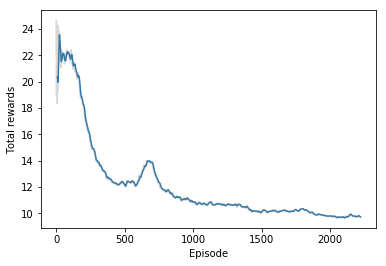

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

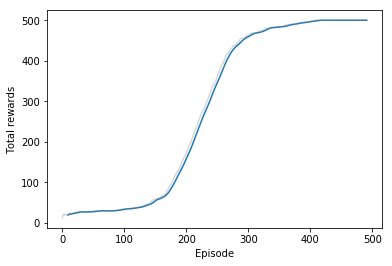

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

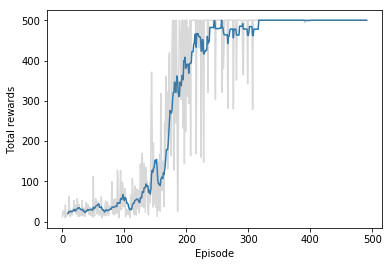

In [63]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.